In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, Conv2D, Conv1D, MaxPooling2D, Input
from tensorflow.keras.models import Model
from tensorflow import keras, config
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
print("GPUs Available: ", len(config.list_physical_devices('GPU')))

In [ ]:
# Global settings
IMAGE_TARGET_SIZE = (5, 1400, 1)
BATCH_SIZE =  128

In [ ]:

%load_ext autoreload
%autoreload 2

from morse_helpers import create_sets
from morse_label_funcs import  labels_to_one_hot_positions_categorical, letter_n_to_one_hot_positions_categorical, position_regression

(image_fnames, morse_labels) = create_sets(
    [
        ["./training_data/MorseTrainSet_04/GEN04_VER_000/", 'wordsMatrices_04_000', "Words_04_000.csv"],
        # ["./training_data/MorseTrainSet_04/GEN04_VER_100/", 'wordsMatrices_04_100', "Words_04_100.csv"],
        # ["./training_data/MorseTrainSet_04/GEN04_VER_200/", 'wordsMatrices_04_200', "Words_04_200.csv"],
        # ["./training_data/MorseTrainSet_04/GEN04_VER_210/", 'wordsMatrices_04_210', "Words_04_210.csv"],
        # ["./training_data/MorseTrainSet_04/GEN04_VER_220/", 'wordsMatrices_04_220', "Words_04_220.csv"],

        # ["./training_data/MorseTrainSet_11/GEN11_VER_000/", 'wordsMatrices_11_000', "Words_11_000.csv"],
        # ["./training_data/MorseTrainSet_11/GEN11_VER_100/", 'wordsMatrices_11_100', "Words_11_100.csv"],
        # ["./training_data/MorseTrainSet_11/GEN11_VER_200/", 'wordsMatrices_11_200', "Words_11_200.csv"],
        # ["./training_data/MorseTrainSet_11/GEN11_VER_210/", 'wordsMatrices_11_210', "Words_11_210.csv"],
        # ["./training_data/MorseTrainSet_11/GEN11_VER_220/", 'wordsMatrices_11_220', "Words_11_220.csv"],

    ], 
    IMAGE_TARGET_SIZE,
    position_regression,
    letter_n=1
)

In [ ]:
from morse_helpers import create_all_sets

TEST_SPLIT_SIZE = 0.90
VALIDATION_SPLIT_SIZE = 0.90

train, labels, train_validation, labels_validation, train_test, labels_test = create_all_sets(
    image_fnames, morse_labels, TEST_SPLIT_SIZE, VALIDATION_SPLIT_SIZE, shuffle_before_test_split=True)

In [ ]:
from morse_helpers import Image_Generator, zeropad_randomly

training_batch_generator = Image_Generator(train, labels, BATCH_SIZE, IMAGE_TARGET_SIZE, [zeropad_randomly])
validation_batch_generator = Image_Generator(train_validation, labels_validation, BATCH_SIZE, IMAGE_TARGET_SIZE, [zeropad_randomly])
test_batch_generator = Image_Generator(train_test, labels_test, BATCH_SIZE, IMAGE_TARGET_SIZE, [])

In [ ]:
# t, l = training_batch_generator.__getitem__(0)

# for i in range(10):
#     print(l[i] * 1400)
#     fig = plt.figure(figsize=(30,5))
#     plt.xlim(0, 800)
#     rolled = np.pad(t[i], [(0,0),(0,0), (0,0)], mode='constant')[:, 0:-1]
#     rolled[:, int(l[i] * 1400)] = 1
#     plt.imshow(rolled)
#     plt.show()

In [ ]:

input_layer     = Input(shape=IMAGE_TARGET_SIZE)
cropped = keras.layers.Cropping2D(cropping=((0, 0), (0,1000)), data_format=None)(input_layer)
pool           = MaxPooling2D(pool_size=(2,2),padding="same")(cropped)

conv1           = Conv2D(80,(3,5),padding="same",activation="relu")(pool)
pool1           = MaxPooling2D(pool_size=(2,2),padding="same")(conv1)

conv2           = Conv2D(80,(1,7),padding="same",activation="relu")(pool1)
pool2           = MaxPooling2D(pool_size=(1,2),padding="same")(conv2)

conv3           = Conv2D(80,(1,11),padding="same",activation="relu")(pool2)
pool3           = MaxPooling2D(pool_size=(1,2),padding="same")(conv3)

conv4           = Conv2D(80,(1,13),padding="same",activation="relu")(pool3)
pool4           = MaxPooling2D(pool_size=(1,2),padding="same")(conv4)

conv5           = Conv2D(80,(1,11),padding="same",activation="relu")(pool4)
pool5           = MaxPooling2D(pool_size=(1,2),padding="same")(conv5)

conv6           = Conv2D(80,(1,9),padding="same",activation="relu")(pool5)
pool6           = MaxPooling2D(pool_size=(1,2),padding="same")(conv6)

conv7           = Conv2D(80,(1,5),padding="same",activation="relu")(pool6)
pool7           = MaxPooling2D(pool_size=(1,2),padding="same")(conv7)

flat            = Flatten()(pool7)

output_layer    = Dense(1)(flat)
model           = Model(inputs=input_layer, outputs=output_layer)
print(model.summary())
model.compile(loss='mse', optimizer='adam', metrics=["mean_absolute_error"])

init_epoch = 0

In [ ]:

NUM_EPOCHS = 5

def fit_model(epochs):
	
	global init_epoch
	history = model.fit(training_batch_generator,
	                   steps_per_epoch = int(len(train) // BATCH_SIZE),
	                   epochs = epochs + init_epoch,
					   initial_epoch=init_epoch,
	                   verbose =1,
	                   validation_data = validation_batch_generator,
	                   validation_steps = int(len(train_validation) // BATCH_SIZE))
	
	
	init_epoch += epochs
	return history

history = fit_model(NUM_EPOCHS)


In [ ]:
predictions = model.predict(test_batch_generator)

In [ ]:
def show_image(img):
    fig = plt.figure(figsize=(30,5))
    plt.xlim(0, 400)
    plt.imshow(img)
    plt.show()
    return fig

In [ ]:
# import sys
# np.set_printoptions(threshold=sys.maxsize)

def get_deviating_predictions(above_pixels):
    regression_differences = []
    indexer = 0

    for imgs_batch, labels_batch in test_batch_generator:

        for i in range(len(imgs_batch)):

            pred = predictions[indexer] * IMAGE_TARGET_SIZE[1]
            test_label = labels_batch[i] * IMAGE_TARGET_SIZE[1]

            if abs(pred - test_label) > above_pixels:
                regression_differences.append([pred, test_label, imgs_batch[i]])

            indexer += 1

    return regression_differences

above_pixels = 3

deviating_predictions = get_deviating_predictions(above_pixels=above_pixels)

print("Total predictions", len(predictions))
print("Total predictions off by more than pixels", above_pixels, " : ", len(deviating_predictions))
print("Percentage incorrect", round( (len(deviating_predictions) / len(predictions) * 100), 2), "%")

In [ ]:

counter = 0   
for diff in deviating_predictions:

    counter += 1
    if counter > 30:
        break

    pred, correct, img = diff

    img_pred = img.copy()
    img_correct = img.copy()

    print('Prediction', pred)
    img_pred[:, int(pred)] = 1
    show_image(img_pred)

    print('Correct', correct)
    img_correct[:, int(correct)] = 1
    show_image(img_correct)

    print("----------------------------------------------------------------------------------------")


In [ ]:
import matplotlib.backends.backend_pdf as mpt

def right_roll_image_by_n(img, roll_value_n):
    return np.roll(img, roll_value_n, axis=1)

def get_label_prediction(img, model, img_width): 
    x_right_rolled_exp_dim = np.expand_dims(img, axis=0)
    single_predict = model.predict(x_right_rolled_exp_dim)
    return single_predict[0] * img_width



def roll_and_display_img(img, indexer):

    image_right_rolled = right_roll_image_by_n(img, int(-10 + (indexer / 5)))

    label_prediction = get_label_prediction(image_right_rolled, model, IMAGE_TARGET_SIZE[1])

    # Draw vertical line
    image_right_rolled[:, int(label_prediction)] = 1

    fig = show_image(image_right_rolled)
    pdf.savefig( fig )


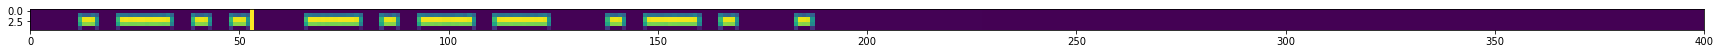

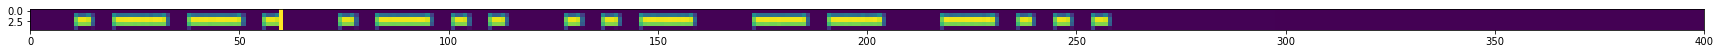

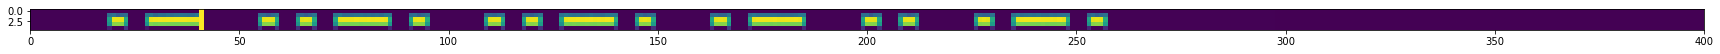

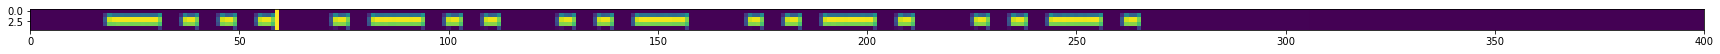

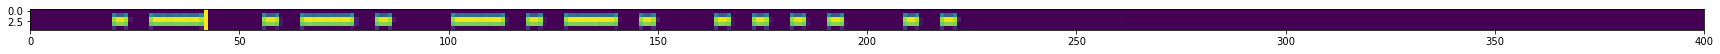

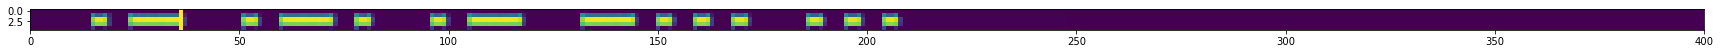

In [58]:
# %%capture 
# capture means suppress output

pdf = mpt.PdfPages("single_predictions_rolled_randomly.pdf")

single_image_batch, single_label_batch = test_batch_generator.__getitem__(0)

for i in range(len(single_image_batch)):
    roll_and_display_img(single_image_batch[i], i)
    
pdf.close()